# Introdução às Redes Neurais Convolucionais em Grafos para Séries Temporais

As **Redes Neurais Convolucionais em Grafos** (Graph Convolutional Networks, ou GCNs) têm se mostrado uma ferramenta poderosa para capturar padrões complexos em dados estruturados em forma de grafos, como redes de transporte, redes sociais e interações moleculares. No entanto, muitos problemas no mundo real também envolvem uma dimensão temporal, onde as relações entre as entidades mudam com o tempo. Isso exige a criação de modelos capazes de capturar **dependências espaciais** e **temporais** simultaneamente.

A combinação dessas duas dimensões resulta em uma nova classe de problemas conhecidos como **Redes Neurais Espaciais-Temporais em Grafos** (Spatio-Temporal Graph Neural Networks, ou ST-GNNs). Esses modelos são aplicados em uma variedade de tarefas, como previsão de tráfego, análise de redes de sensores e modelagem de interações dinâmicas em redes sociais.

Nesta apresentação, exploraremos como a GCN pode ser expandida para lidar com séries temporais, capturando tanto a estrutura do grafo quanto as mudanças ao longo do tempo. Vamos focar em exemplos práticos, como a **previsão de tráfego**, onde o tráfego entre diferentes segmentos de estrada é modelado como um grafo cujas características variam ao longo do tempo.

## Definição

Dado um grafo dinâmico $G(t) = (V, E, X_V(t), X_E(t))$, onde:

- $V$ é o conjunto de nós (vértices),
- $E$ é o conjunto de arestas (conexões entre os nós),
- $X_V(t) \in \mathbb{R}^{|V| \times d_V}$ representa as características dos nós (vértices) no tempo $t$, sendo $d_V$ a dimensionalidade das características dos nós,
- $X_E(t) \in \mathbb{R}^{|E| \times d_E}$ representa as características das arestas no tempo $t$, sendo $d_E$ a dimensionalidade das características das arestas.

![example](st_gnn.png)

# Motivação: Previsão de Trafégo

Neste exemplo, mostramos como prever as condições de tráfego utilizando redes neurais baseadas em grafos **(GNNs)** combinadas com **LSTM**. O foco é prever os valores futuros da velocidade do tráfego com base em um histórico de dados de uma coleção de segmentos de estrada.

Uma solução tradicional para este tipo de problema é tratar a velocidade de tráfego de cada segmento de estrada como uma série temporal individual, prevendo os valores futuros com base nos dados passados do próprio segmento. Entretanto, essa abordagem não considera as influências que os segmentos vizinhos exercem entre si.

Para capturar as interações complexas entre os diferentes segmentos de estrada, podemos modelar a rede de tráfego como um grafo, onde a velocidade do tráfego é representada como um sinal associado a esse grafo. Nesta abordagem, implementamos uma arquitetura de rede neural capaz de processar séries temporais sobre um grafo. Primeiramente, mostramos como preparar os dados e criar um `tf.data.Dataset` para previsão com grafos. Em seguida, desenvolvemos um modelo que combina camadas de convolução em grafos com LSTM para realizar a previsão.

## Carregando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import os
import typing
import matplotlib.pyplot as plt
import networkx as nx

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2024-10-06 17:46:56.271681: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-06 17:46:56.281573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 17:46:56.292550: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 17:46:56.295726: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-06 17:46:56.304245: I tensorflow/core/platform/cpu_feature_guar

## Dados

Utilizamos um conjunto de dados reais de velocidade de tráfego chamado **PeMSD7**. A versão do dataset está no repositório na pasta `data`.

O conjunto de dados **PeMSD7** abrange o **Distrito 7 da Califórnia** e consiste nas velocidades de tráfego registradas por **228 sensores** durante o período de maio a junho de 2012, apenas nos dias úteis, com um intervalo de coleta de **5 minutos**.

O conjunto de dados é composto por dois arquivos principais:

- **PeMSD7_W_228.csv**: Contém as distâncias entre as 228 estações localizadas no Distrito 7 da Califórnia.
- **PeMSD7_V_228.csv**: Contém as velocidades de tráfego coletadas nessas estações durante os dias úteis dos meses de maio e junho de 2012, com um intervalo de 5 minutos entre as medições.

Uma descrição completa do conjunto de dados pode ser encontrada no artigo de Yu et al. (2018).


![](PeMSD7-datasets.png)

In [2]:
# Lendo os arquivos CSV usando numpy
route_distances = np.loadtxt("../../data/pemsd7/PeMSD7_W_228.csv", delimiter=",")
speeds_array = np.loadtxt("../../data/pemsd7/PeMSD7_V_228.csv", delimiter=",")

### Grafo

In [3]:
route_distances

array([[    0.  ,  3165.94,  8731.54, ..., 22614.08, 26339.9 , 10012.42],
       [ 3165.94,     0.  ,  5625.76, ..., 21118.47, 24716.98,  9915.24],
       [ 8731.54,  5625.76,     0.  , ..., 20827.51, 23992.78, 13057.44],
       ...,
       [22614.08, 21118.47, 20827.51, ...,     0.  ,  3825.01, 13725.79],
       [26339.9 , 24716.98, 23992.78, ...,  3825.01,     0.  , 17550.36],
       [10012.42,  9915.24, 13057.44, ..., 13725.79, 17550.36,     0.  ]])

In [4]:
route_distances.shape

(228, 228)

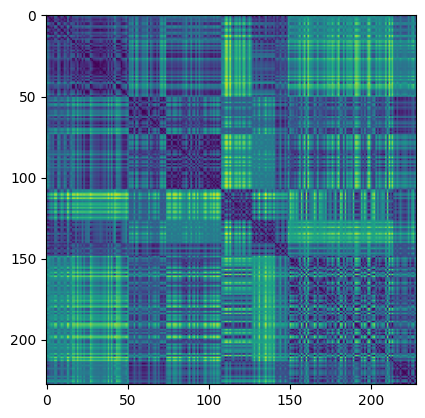

In [5]:
plt.imshow(route_distances)

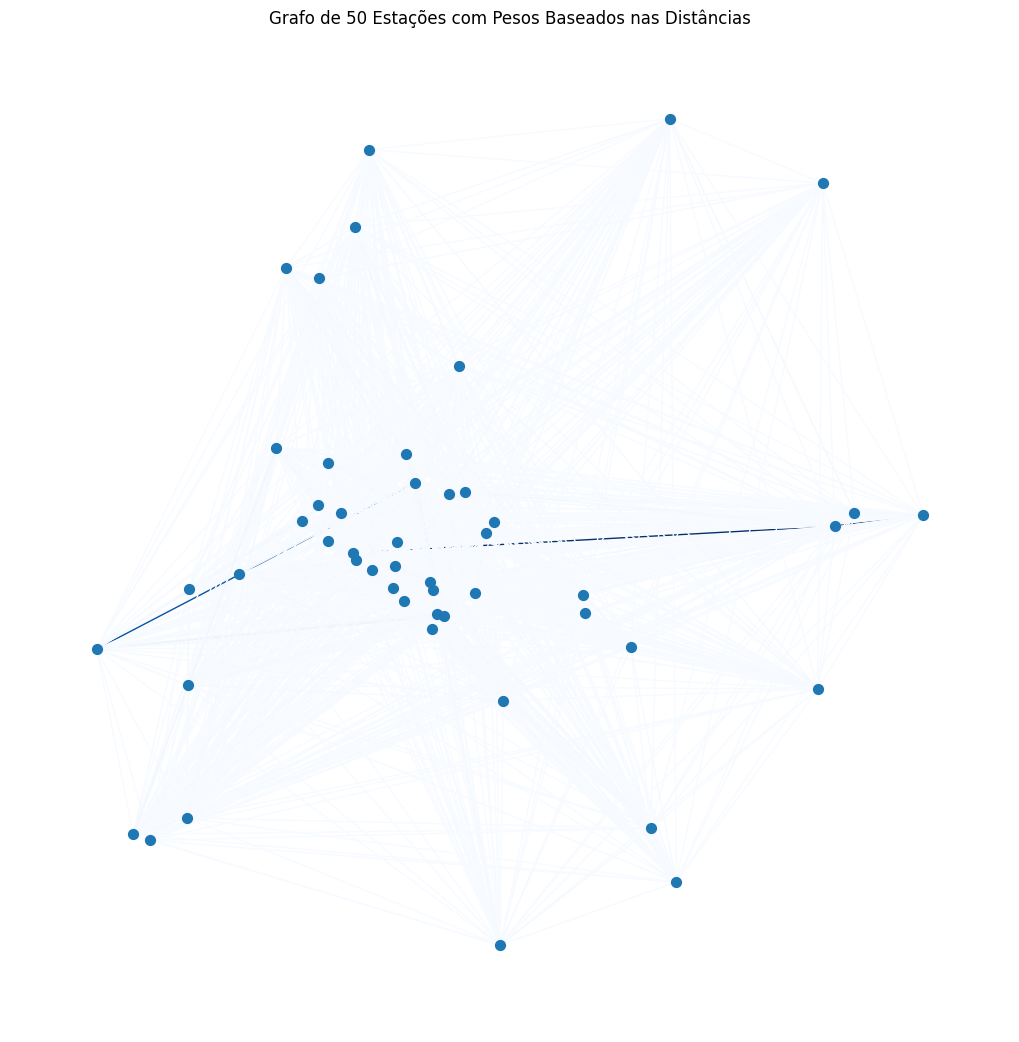

In [6]:
# Função para subamostrar as estações
def subamostrar_estacoes(route_distances, num_estacoes):
    indices = np.random.choice(route_distances.shape[0], num_estacoes, replace=False)
    sub_route_distances = route_distances[np.ix_(indices, indices)]
    return sub_route_distances, indices

num_estacoes = 50  # Altere para o número desejado de estações

# Subamostrando as estações
sub_route_distances, estacoes_indices = subamostrar_estacoes(route_distances, num_estacoes)

# Criando o grafo diretamente da matriz de adjacência (distâncias subamostradas)
G = nx.from_numpy_array(sub_route_distances)

# Plotando o grafo com as arestas ponderadas pelas distâncias
pos = nx.spring_layout(G, seed=42)  # Layout do grafo
edges = G.edges(data=True)
weights = [1 / (w['weight'] + 1) for _, _, w in edges]  # Pesos das arestas

plt.figure(figsize=(10, 10))
nx.draw(G, pos, node_size=50, edge_color=weights, edge_cmap=plt.cm.Blues)

plt.title(f"Grafo de {num_estacoes} Estações com Pesos Baseados nas Distâncias")
plt.show()

In [7]:
list(edges)

[(0, 1, {'weight': 31395.22}),
 (0, 2, {'weight': 17298.43}),
 (0, 3, {'weight': 29065.81}),
 (0, 4, {'weight': 9467.84}),
 (0, 5, {'weight': 11362.93}),
 (0, 6, {'weight': 16836.79}),
 (0, 7, {'weight': 32262.75}),
 (0, 8, {'weight': 15952.55}),
 (0, 9, {'weight': 31381.7}),
 (0, 10, {'weight': 6819.71}),
 (0, 11, {'weight': 17136.87}),
 (0, 12, {'weight': 5815.41}),
 (0, 13, {'weight': 14191.73}),
 (0, 14, {'weight': 20056.36}),
 (0, 15, {'weight': 5910.25}),
 (0, 16, {'weight': 6253.66}),
 (0, 17, {'weight': 23217.98}),
 (0, 18, {'weight': 16935.72}),
 (0, 19, {'weight': 1984.64}),
 (0, 20, {'weight': 19286.34}),
 (0, 21, {'weight': 22376.18}),
 (0, 22, {'weight': 2598.13}),
 (0, 23, {'weight': 17156.32}),
 (0, 24, {'weight': 16839.93}),
 (0, 25, {'weight': 6051.23}),
 (0, 26, {'weight': 10467.28}),
 (0, 27, {'weight': 13673.32}),
 (0, 28, {'weight': 5884.26}),
 (0, 29, {'weight': 13798.84}),
 (0, 30, {'weight': 2521.25}),
 (0, 31, {'weight': 31395.22}),
 (0, 32, {'weight': 16681.62

### Série Temporal

In [8]:
speeds_array

array([[71.1, 66. , 64.6, ..., 69.3, 67.7, 68.9],
       [68.1, 66.8, 61.7, ..., 67.7, 68.8, 68.8],
       [68. , 64.3, 66.6, ..., 70.2, 69.1, 68.7],
       ...,
       [68.9, 37.9, 68.8, ..., 68.7, 67.5, 19.7],
       [69.2, 37.8, 68.7, ..., 67.7, 67.4, 19.5],
       [68.6, 52.9, 68.6, ..., 68.1, 68.5, 19.1]])

In [9]:
speeds_array.shape

(12672, 228)

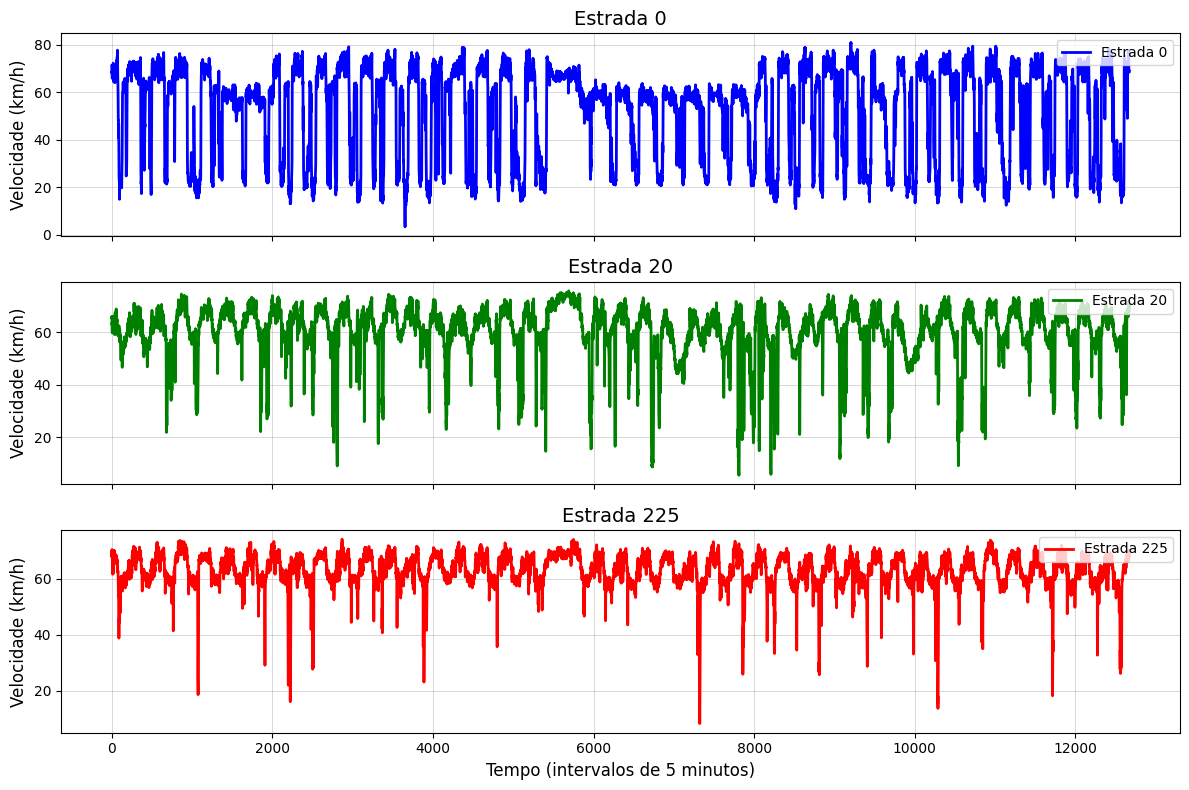

In [10]:
# Selecionar algumas estradas para plotar
selected_routes = [0, 20, 225]

# Criar subplots para as séries temporais das velocidades para as estradas selecionadas
fig, axs = plt.subplots(len(selected_routes), 1, figsize=(12, 8), sharex=True)

# Definir um conjunto de cores e estilos de linha para melhorar a visualização
colors = ['b', 'g', 'r']

for i, route in enumerate(selected_routes):
    axs[i].plot(speeds_array[:, route], color=colors[i], linewidth=2, label=f'Estrada {route}')
    axs[i].set_title(f"Estrada {route}", fontsize=14)
    axs[i].set_ylabel("Velocidade (km/h)", fontsize=12)
    axs[i].grid(True, which='both', linewidth=0.5, alpha=0.7)
    axs[i].legend(loc='upper right', fontsize=10)

# Definir rótulo do eixo x apenas para o último subplot
axs[-1].set_xlabel("Tempo (intervalos de 5 minutos)", fontsize=12)

# Melhorar layout dos subplots
plt.tight_layout()
plt.show()

## Subamostragem de Estradas

Para reduzir o tamanho do problema e tornar o treinamento mais rápido, trabalharemos com uma amostra de 26 estradas das 228 disponíveis no conjunto de dados. As estradas foram escolhidas começando pela estrada 0, selecionando as 5 estradas mais próximas a ela, e repetindo esse processo até obtermos 25 estradas. 

Você pode optar por qualquer outro subconjunto de estradas. Escolhemos as estradas dessa forma para aumentar a probabilidade de selecionar estradas cujas séries temporais de velocidade estejam correlacionadas.

`sample_routes` contém os IDs das estradas selecionadas.


In [11]:
sample_routes = [
    0,
    1,
    4,
    7,
    8,
    11,
    15,
    108,
    109,
    114,
    115,
    118,
    120,
    123,
    124,
    126,
    127,
    129,
    130,
    132,
    133,
    136,
    139,
    144,
    147,
    216,
]
route_distances = route_distances[np.ix_(sample_routes, sample_routes)] 
speeds_array = speeds_array[:, sample_routes]

print(f"route_distances shape={route_distances.shape}")
print(f"speeds_array shape={speeds_array.shape}")

route_distances shape=(26, 26)
speeds_array shape=(12672, 26)


In [12]:
route_distances.shape

(26, 26)

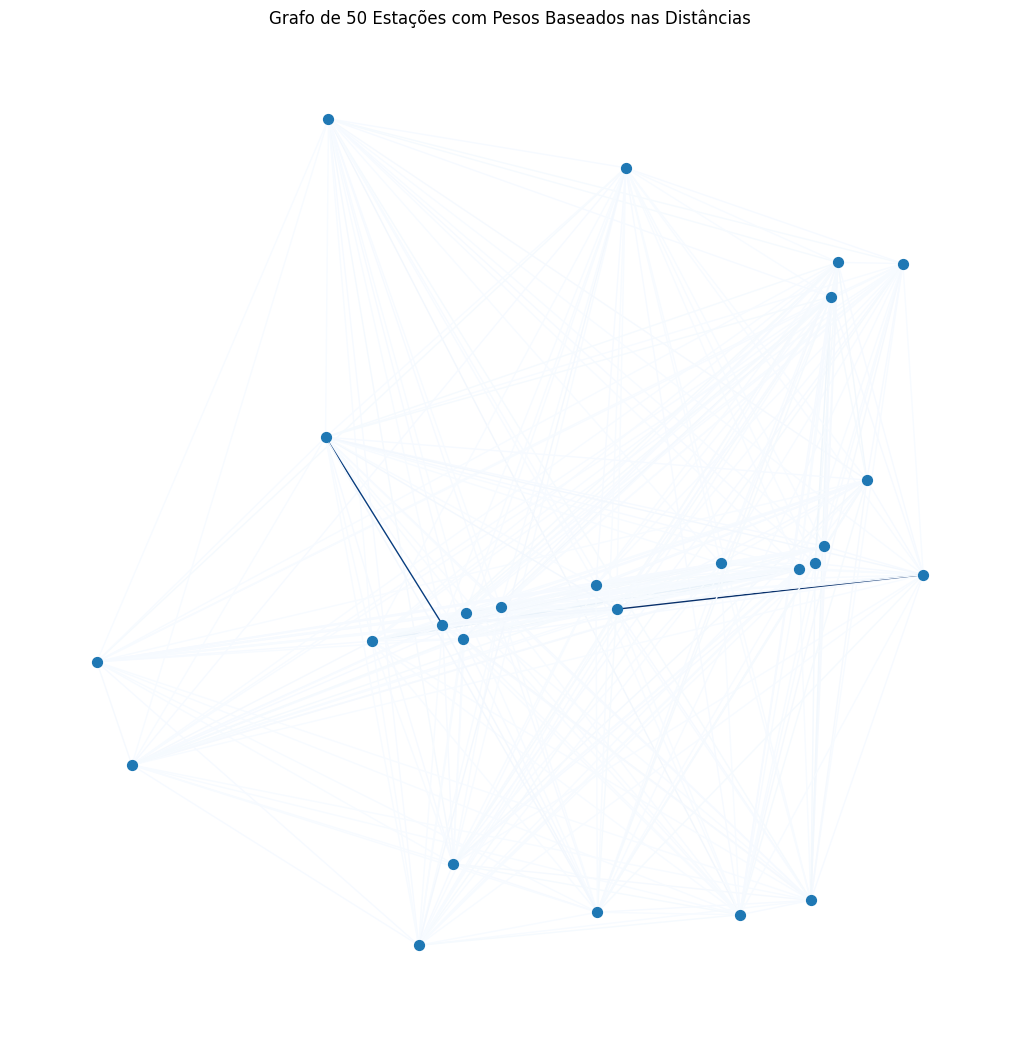

In [13]:
# Criando o grafo diretamente da matriz de adjacência (distâncias subamostradas)
G = nx.from_numpy_array(route_distances)

# Plotando o grafo com as arestas ponderadas pelas distâncias
pos = nx.spring_layout(G, seed=42)  # Layout do grafo
edges = G.edges(data=True)
weights = [1 / (w['weight'] + 1) for _, _, w in edges]  # Pesos das arestas

plt.figure(figsize=(10, 10))
nx.draw(G, pos, node_size=50, edge_color=weights, edge_cmap=plt.cm.Blues)

plt.title(f"Grafo de {num_estacoes} Estações com Pesos Baseados nas Distâncias")
plt.show()

<Figure size 1500x1500 with 0 Axes>

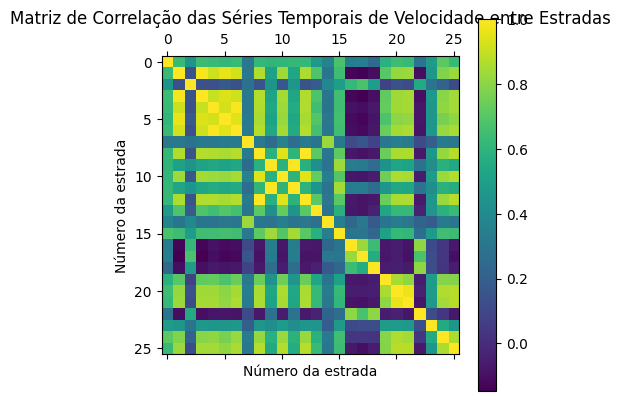

In [14]:
# Criar o gráfico de matriz de correlação com legenda
plt.figure(figsize=(15, 15))
corr_matrix = np.corrcoef(speeds_array.T)

# Plot da matriz de correlação
cax = plt.matshow(corr_matrix)

# Adicionar barra de cores (legenda)
plt.colorbar(cax)

# Definir rótulos para os eixos
plt.xlabel("Número da estrada")
plt.ylabel("Número da estrada")

plt.title("Matriz de Correlação das Séries Temporais de Velocidade entre Estradas")
plt.show()


## Spliting: Treino, validação e teste

In [15]:
train_size, val_size = 0.6, 0.2


def preprocess(data_array: np.ndarray, train_size: float, val_size: float):
    """Splits data into train/val/test sets and normalizes the data.

    Args:
        data_array: ndarray of shape `(num_time_steps, num_routes)`
        train_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the train split.
        val_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the validation split.

    Returns:
        `train_array`, `val_array`, `test_array`
    """

    num_time_steps = data_array.shape[0]
    num_train, num_val = (
        int(num_time_steps * train_size),
        int(num_time_steps * val_size),
    )
    train_array = data_array[:num_train]
    mean, std = train_array.mean(axis=0), train_array.std(axis=0)

    train_array = (train_array - mean) / std
    val_array = (data_array[num_train : (num_train + num_val)] - mean) / std
    test_array = (data_array[(num_train + num_val) :] - mean) / std

    return train_array, val_array, test_array


train_array, val_array, test_array = preprocess(speeds_array, train_size, val_size)

print(f"train set size: {train_array.shape}")
print(f"validation set size: {val_array.shape}")
print(f"test set size: {test_array.shape}")

train set size: (7603, 26)
validation set size: (2534, 26)
test set size: (2535, 26)


## Criação de Datasets no TensorFlow

Usamos a função `timeseries_dataset_from_array()` da Keras para criar os datasets para o nosso problema de previsão de tráfego. A função `create_tf_dataset()` recebe como entrada um `numpy.ndarray` e retorna um `tf.data.Dataset`. Nessa função, o argumento `input_sequence_length` é definido como **12**, representando o comprimento da sequência de entrada, e o argumento `forecast_horizon` é definido como **3**, representando o horizonte de previsão.

### multi_horizon

O argumento `multi_horizon` determina como os alvos (targets) serão gerados:
- Se `multi_horizon=True`, o modelo fará uma previsão para os passos de tempo t+T+1, t+T+2 e t+T+3. Portanto, o alvo terá a forma `(batch_size, forecast_horizon, num_routes)`, onde `forecast_horizon` será igual a 3.
- Se `multi_horizon=False`, o modelo fará a previsão apenas para o último passo de tempo t+T+3. Nesse caso, o alvo terá a forma `(batch_size, 1, num_routes)`.

## Nossos parâmetros

No nosso exemplo, usamos os seguintes parâmetros:
- `input_sequence_length = 12`: Usamos os últimos 12 valores de velocidade de cada estrada como entrada.
- `forecast_horizon = 3`: Prevemos a velocidade para os 3 próximos passos de tempo.
- `batch_size = 64`: Cada lote de dados terá 64 amostras.
- `multi_horizon = False`: Fazemos a previsão apenas para o último passo de tempo t+T+3.

A entrada do tensor em cada batch terá a forma `(batch_size, input_sequence_length, num_routes, 1)`, onde a última dimensão é 1, para representar uma única série temporal por estrada. Caso quiséssemos usar várias séries temporais (como temperatura ou outro dado), a última dimensão poderia ser maior. Neste exemplo, a previsão é feita somente com base nos valores históricos de velocidade.

A função `create_tf_dataset()` foi usada para criar os datasets de treino, validação e teste:

- `train_dataset` e `val_dataset` são criados a partir de `train_array` e `val_array`, respectivamente.
- `test_dataset` é criado a partir de `test_array`, com um `batch_size` igual ao número total de amostras de teste, sem embaralhamento (`shuffle=False`) e com `multi_horizon=True` ou `multi_horizon=False`, dependendo do objetivo da previsão.

In [16]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

batch_size = 64
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False


def create_tf_dataset(
    data_array: np.ndarray,
    input_sequence_length: int,
    forecast_horizon: int,
    batch_size: int = 128,
    shuffle=True,
    multi_horizon=True,
):
    """Creates tensorflow dataset from numpy array.

    This function creates a dataset where each element is a tuple `(inputs, targets)`.
    `inputs` is a Tensor
    of shape `(batch_size, input_sequence_length, num_routes, 1)` containing
    the `input_sequence_length` past values of the timeseries for each node.
    `targets` is a Tensor of shape `(batch_size, forecast_horizon, num_routes)`
    containing the `forecast_horizon`
    future values of the timeseries for each node.

    Args:
        data_array: np.ndarray with shape `(num_time_steps, num_routes)`
        input_sequence_length: Length of the input sequence (in number of timesteps).
        forecast_horizon: If `multi_horizon=True`, the target will be the values of the timeseries for 1 to
            `forecast_horizon` timesteps ahead. If `multi_horizon=False`, the target will be the value of the
            timeseries `forecast_horizon` steps ahead (only one value).
        batch_size: Number of timeseries samples in each batch.
        shuffle: Whether to shuffle output samples, or instead draw them in chronological order.
        multi_horizon: See `forecast_horizon`.

    Returns:
        A tf.data.Dataset instance.
    """

    inputs = timeseries_dataset_from_array(
        np.expand_dims(data_array[:-forecast_horizon], axis=-1),
        None,
        sequence_length=input_sequence_length,
        shuffle=False,
        batch_size=batch_size,
    )

    target_offset = (
        input_sequence_length
        if multi_horizon
        else input_sequence_length + forecast_horizon - 1
    )
    target_seq_length = forecast_horizon if multi_horizon else 1
    targets = timeseries_dataset_from_array(
        data_array[target_offset:],
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(100)

    return dataset.prefetch(16).cache()


train_dataset, val_dataset = (
    create_tf_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
    for data_array in [train_array, val_array]
)

test_dataset = create_tf_dataset(
    test_array,
    input_sequence_length,
    forecast_horizon,
    batch_size=test_array.shape[0],
    shuffle=False,
    multi_horizon=multi_horizon,
)

In [17]:
train_dataset

<CacheDataset element_spec=(TensorSpec(shape=(None, None, 26, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 26), dtype=tf.float64, name=None))>

## Séries de entrada e saída do modelo

Abaixo exibimos como são as séries que serão usadas como treino e teste para cada nó.

2024-10-06 17:47:32.115894: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-10-06 17:47:32.117674: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


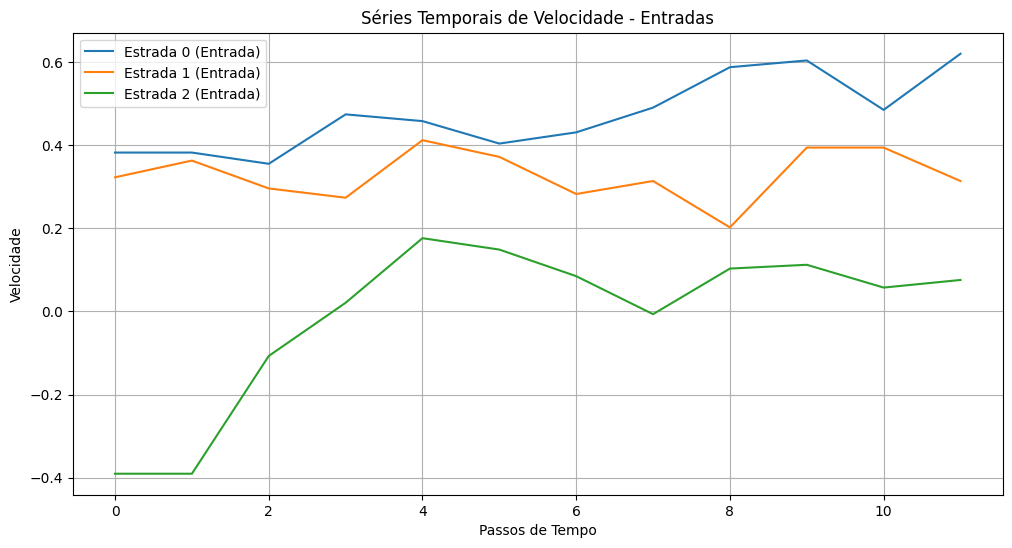

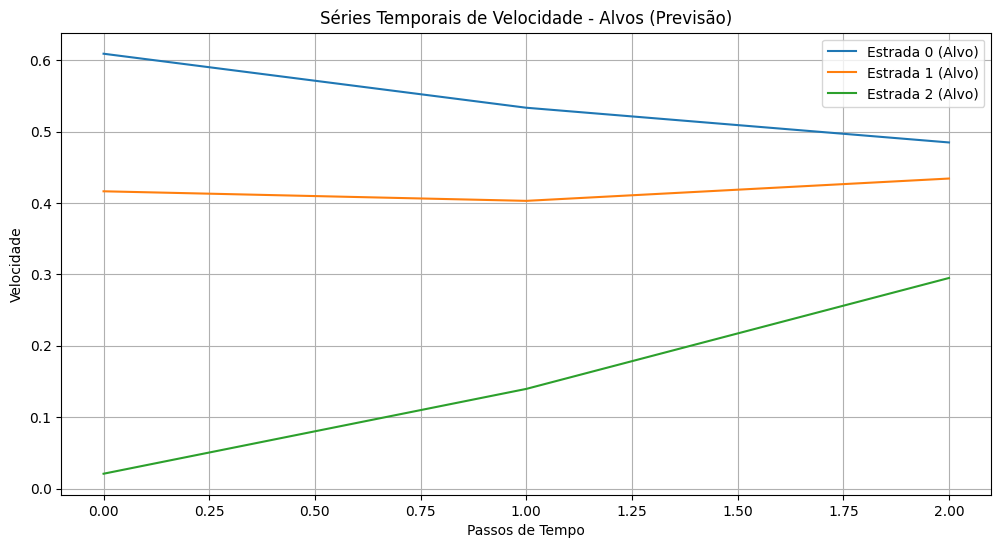

In [18]:
for batch_inputs, batch_targets in train_dataset.take(1):
    batch_inputs = batch_inputs.numpy()
    batch_targets = batch_targets.numpy()

# Selecionar algumas estradas e exibir suas séries temporais
selected_routes = [0, 1, 2]  # Escolhendo três rotas como exemplo

plt.figure(figsize=(12, 6))
for route in selected_routes:
    plt.plot(batch_inputs[0, :, route, 0], label=f'Estrada {route} (Entrada)')

plt.title("Séries Temporais de Velocidade - Entradas")
plt.xlabel("Passos de Tempo")
plt.ylabel("Velocidade")
plt.legend()
plt.grid(True)
plt.show()

# Plotar as previsões (targets)
plt.figure(figsize=(12, 6))
for route in selected_routes:
    plt.plot(batch_targets[0, :, route], label=f'Estrada {route} (Alvo)')

plt.title("Séries Temporais de Velocidade - Alvos (Previsão)")
plt.xlabel("Passos de Tempo")
plt.ylabel("Velocidade")
plt.legend()
plt.grid(True)
plt.show()